In [1]:
!nvidia-smi
!nvcc --version

Sat Jan 31 20:29:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Part 1: Matrix Multiplication on the CPU

%%writefile matrix_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrixMultiplyCPU(float *A, float *B, float *C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            float sum = 0.0f;
            for (int k = 0; k < N; k++) {
                sum += A[i * N + k] * B[k * N + j];
            }
            C[i * N + j] = sum;
        }
    }
}

int main(int argc, char **argv) {
    // allow matrix size as input
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    float *A = (float *)malloc(size);
    float *B = (float *)malloc(size);
    float *C = (float *)malloc(size);

    // Initialize matrices
    for (int i = 0; i < N * N; i++) {
        A[i] = (float)(rand() % 100) / 100.0f;
        B[i] = (float)(rand() % 100) / 100.0f;
    }

    clock_t start = clock();
    matrixMultiplyCPU(A, B, C, N);
    clock_t end = clock();

    double elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("CPU execution time (N=%d): %f seconds\n", N, elapsed);

    free(A); free(B); free(C);
    return 0;
}

Writing matrix_cpu.c


In [3]:
!gcc -O2 matrix_cpu.c -o matrix_cpu
!./matrix_cpu 128
!./matrix_cpu 256
!./matrix_cpu 512
!./matrix_cpu 1024
!./matrix_cpu 1536
!./matrix_cpu 2048
!./matrix_cpu 4096

CPU execution time (N=128): 0.003113 seconds
CPU execution time (N=256): 0.021311 seconds
CPU execution time (N=512): 0.358473 seconds
CPU execution time (N=1024): 3.426111 seconds
CPU execution time (N=1536): 13.690502 seconds
CPU execution time (N=2048): 76.278643 seconds
CPU execution time (N=4096): 749.123215 seconds


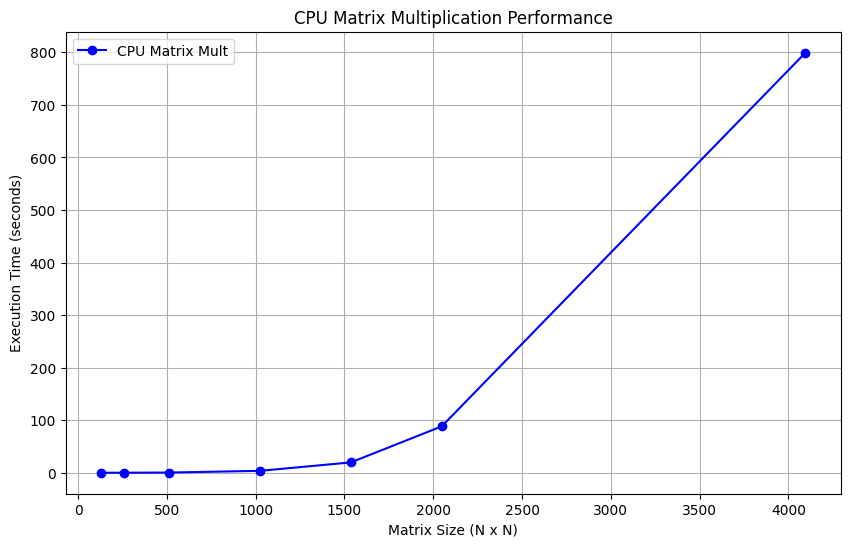

In [4]:
# Graph runtimes for several N values
import matplotlib.pyplot as plt

n = [128, 256, 512, 1024, 1536, 2048, 4096]
cpu_times = [0.002915, 0.023367, 0.328468, 3.583342, 19.639721, 88.299483, 799.240530]

plt.figure(figsize=(10, 6))
plt.plot(n, cpu_times, marker='o', linestyle='-', color='b', label='CPU Matrix Mult')
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Execution Time (seconds)')
plt.title('CPU Matrix Multiplication Performance')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# Part 2: Introduction to CUDA Programming

%%writefile matrix_gpu.cu
#include <stdio.h>
#include <cuda_runtime.h>

// CUDA Kernel: each thread computes one element of C
__global__ void matrixMultiplyGPU(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    // Allocate memory on the Host (CPU)
    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    // Initialize matrices
    for (int i = 0; i < N * N; i++) {
        h_A[i] = (float)(rand() % 100) / 100.0f;
        h_B[i] = (float)(rand() % 100) / 100.0f;
    }

    // Allocate memory on the Device (GPU)
    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    // Copy data from Host to Device
    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    // Define thread block and grid size
    dim3 threadsPerBlock(16, 16);
    dim3 blocksPerGrid((N + 15) / 16, (N + 15) / 16);

    // Timing using CUDA events
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMultiplyGPU<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, N);
    cudaEventRecord(stop);

    // Copy result back to Host
    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("GPU Naïve execution time (N=%d): %f ms\n", N, milliseconds);

    // Cleanup
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Writing matrix_gpu.cu


In [6]:
!nvcc matrix_gpu.cu -o matrix_gpu
!./matrix_gpu 512
!./matrix_gpu 1024
!./matrix_gpu 2048
!./matrix_gpu 4096

GPU Naïve execution time (N=512): 36.425919 ms
GPU Naïve execution time (N=1024): 7.354624 ms
GPU Naïve execution time (N=2048): 7.518496 ms
GPU Naïve execution time (N=4096): 7.262144 ms


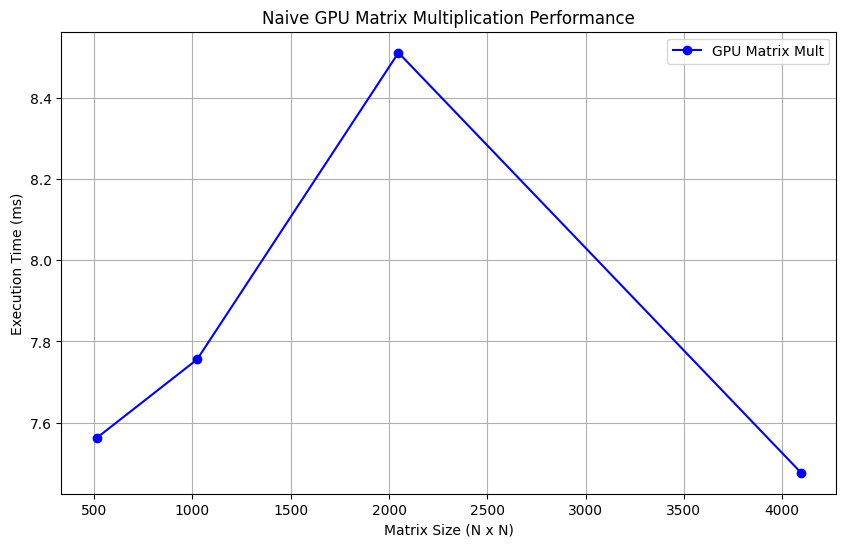

In [7]:
# Graph runtimes for several N values
import matplotlib.pyplot as plt

n = [512, 1024, 2048, 4096]
gpu_times = [7.561920, 7.755808, 8.511264, 7.476608]

plt.figure(figsize=(10, 6))
plt.plot(n, gpu_times, marker='o', linestyle='-', color='b', label='GPU Matrix Mult')
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Execution Time (ms)')
plt.title('Naive GPU Matrix Multiplication Performance')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# Part 4: Optimizing CUDA Code

%%writefile matrix_tiled.cu
#include <stdio.h>
#include <cuda_runtime.h>

#define TILE_WIDTH 16

__global__ void matrixMultiplyTiled(float *A, float *B, float *C, int N) {
    __shared__ float ds_A[TILE_WIDTH][TILE_WIDTH];
    __shared__ float ds_B[TILE_WIDTH][TILE_WIDTH];

    int bx = blockIdx.x; int by = blockIdx.y;
    int tx = threadIdx.x; int ty = threadIdx.y;

    int Row = by * TILE_WIDTH + ty;
    int Col = bx * TILE_WIDTH + tx;

    float Pvalue = 0.0;

    // Loop over the tiles required to compute the C element
    for (int m = 0; m < (N + TILE_WIDTH - 1) / TILE_WIDTH; ++m) {

        // Load tile from A into shared memory
        if (Row < N && (m * TILE_WIDTH + tx) < N)
            ds_A[ty][tx] = A[Row * N + m * TILE_WIDTH + tx];
        else
            ds_A[ty][tx] = 0.0f;

        // Load tile from B into shared memory
        if (Col < N && (m * TILE_WIDTH + ty) < N)
            ds_B[ty][tx] = B[(m * TILE_WIDTH + ty) * N + Col];
        else
            ds_B[ty][tx] = 0.0f;

        __syncthreads(); // Wait for all threads to load their elements

        for (int k = 0; k < TILE_WIDTH; ++k)
            Pvalue += ds_A[ty][k] * ds_B[k][tx];

        __syncthreads(); // Wait before loading next tile
    }

    if (Row < N && Col < N)
        C[Row * N + Col] = Pvalue;
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    for (int i = 0; i < N * N; i++) {
        h_A[i] = (float)(rand() % 100) / 100.0f;
        h_B[i] = (float)(rand() % 100) / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    dim3 dimBlock(TILE_WIDTH, TILE_WIDTH);
    dim3 dimGrid((N + TILE_WIDTH - 1) / TILE_WIDTH, (N + TILE_WIDTH - 1) / TILE_WIDTH);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMultiplyTiled<<<dimGrid, dimBlock>>>(d_A, d_B, d_C, N); //
    cudaEventRecord(stop);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("GPU Tiled execution time (N=%d): %f ms\n", N, milliseconds);

    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Writing matrix_tiled.cu


In [9]:
!nvcc matrix_tiled.cu -o matrix_tiled
!./matrix_tiled 512
!./matrix_tiled 1024
!./matrix_tiled 2048
!./matrix_tiled 4096

GPU Tiled execution time (N=512): 7.695968 ms
GPU Tiled execution time (N=1024): 8.410912 ms
GPU Tiled execution time (N=2048): 7.225184 ms
GPU Tiled execution time (N=4096): 7.328544 ms


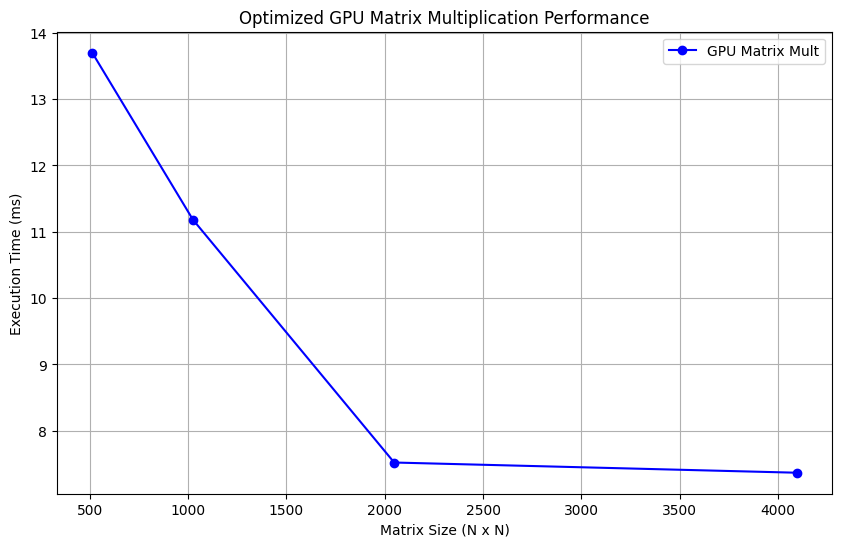

In [10]:
# Graph runtimes for several N values
import matplotlib.pyplot as plt

n = [512, 1024, 2048, 4096]
gpu_times = [13.698304, 11.182656, 7.522112, 7.368384]

plt.figure(figsize=(10, 6))
plt.plot(n, gpu_times, marker='o', linestyle='-', color='b', label='GPU Matrix Mult')
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Execution Time (ms)')
plt.title('Optimized GPU Matrix Multiplication Performance')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
import pandas as pd

n_sizes = ["N=512", "N=1024", "N=2048", "N=4096"]
cpu_data   = [0.328468, 3.583342, 88.299483, 799.240530]
naive_data = [.007561920, .007755808, .008511264, .007476608]
opt_data   = [.013698304, .011182656, .007522112, .007368384]

# Calculate Speedup
speedup_naive = [c / n for c, n in zip(cpu_data, naive_data)]
speedup_opt = [c / o for c, o in zip(cpu_data, opt_data)]

table_data = {
    "Implementation": ["CPU (C)", "Naïve CUDA", "Optimized CUDA", "Speedup (Naïve)", "Speedup (Optimized)"],
    n_sizes[0]: [f"{cpu_data[0]:.3f} sec", f"{naive_data[0]*1000:.2f} ms", f"{opt_data[0]*1000:.2f} ms", f"{speedup_naive[0]:.1f}x", f"{speedup_opt[0]:.1f}x"],
    n_sizes[1]: [f"{cpu_data[1]:.3f} sec", f"{naive_data[1]*1000:.2f} ms", f"{opt_data[1]*1000:.2f} ms", f"{speedup_naive[1]:.1f}x", f"{speedup_opt[1]:.1f}x"],
    n_sizes[2]: [f"{cpu_data[2]:.3f} sec", f"{naive_data[2]*1000:.2f} ms", f"{opt_data[2]*1000:.2f} ms", f"{speedup_naive[2]:.1f}x", f"{speedup_opt[2]:.1f}x"],
    n_sizes[3]: [f"{cpu_data[3]:.3f} sec", f"{naive_data[3]*1000:.2f} ms", f"{opt_data[3]*1000:.2f} ms", f"{speedup_naive[3]:.1f}x", f"{speedup_opt[3]:.1f}x"]
}

# 4. Display Styled Table
df = pd.DataFrame(table_data)
df.style.hide(axis='index').set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center'), ('padding', '10px')]}
])


Implementation,N=512,N=1024,N=2048,N=4096
CPU (C),0.328 sec,3.583 sec,88.299 sec,799.241 sec
Naïve CUDA,7.56 ms,7.76 ms,8.51 ms,7.48 ms
Optimized CUDA,13.70 ms,11.18 ms,7.52 ms,7.37 ms
Speedup (Naïve),43.4x,462.0x,10374.4x,106898.8x
Speedup (Optimized),24.0x,320.4x,11738.7x,108468.9x


In [12]:
#Part 6: Using cuBLAS Library
%%writefile matrix_cublas.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <cublas_v2.h>

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    float *h_A = (float *)malloc(size);
    float *h_B = (float *)malloc(size);
    float *h_C = (float *)malloc(size);

    for (int i = 0; i < N * N; i++) {
        h_A[i] = (float)(rand() % 100) / 100.0f;
        h_B[i] = (float)(rand() % 100) / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc((void**)&d_A, size);
    cudaMalloc((void**)&d_B, size);
    cudaMalloc((void**)&d_C, size);

    cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

    cublasHandle_t handle;
    cublasCreate(&handle);

    float alpha = 1.0f;
    float beta = 0.0f;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);

    // compute C = B * A in column-major.
    cublasSgemm(handle, CUBLAS_OP_N, CUBLAS_OP_N, N, N, N, &alpha, d_B, N, d_A, N, &beta, d_C, N);
    cudaEventRecord(stop);

    cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("cuBLAS execution time (N=%d): %f ms\n", N, milliseconds);

    cublasDestroy(handle);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Writing matrix_cublas.cu


In [13]:
!nvcc matrix_cublas.cu -o matrix_cublas -lcublas
!./matrix_cublas 512
!./matrix_cublas 1024
!./matrix_cublas 2048
!./matrix_cublas 4096

cuBLAS execution time (N=512): 41.255550 ms
cuBLAS execution time (N=1024): 6.289824 ms
cuBLAS execution time (N=2048): 12.949856 ms
cuBLAS execution time (N=4096): 55.158752 ms


In [14]:
# Update table
import pandas as pd

n_sizes = ["N=512", "N=1024", "N=2048", "N=4096"]

cpu_data   = [0.328468, 3.583342, 88.299483, 799.240530]  # in seconds
naive_data = [.007561920, .007755808, .008511264, .007476608] # in seconds
opt_data   = [.013698304, .011182656, .007522112, .007368384] # in seconds

cublas_data = [.006000480, .006423040, .011753472, .053445343]    # in seconds (converted from ms)

table_data = {
    "Implementation": ["CPU (C)", "Naïve CUDA", "Optimized CUDA", "cuBLAS"],
    n_sizes[0]: [
        f"{cpu_data[0]:.3f} sec",
        f"{naive_data[0]*1000:.2f} ms",
        f"{opt_data[0]*1000:.2f} ms",
        f"{cublas_data[0]*1000:.2f} ms"
    ],
    n_sizes[1]: [
        f"{cpu_data[1]:.3f} sec",
        f"{naive_data[1]*1000:.2f} ms",
        f"{opt_data[1]*1000:.2f} ms",
        f"{cublas_data[1]*1000:.2f} ms"
    ],
    n_sizes[2]: [
        f"{cpu_data[2]:.3f} sec",
        f"{naive_data[2]*1000:.2f} ms",
        f"{opt_data[2]*1000:.2f} ms",
        f"{cublas_data[2]*1000:.2f} ms"
    ],
    n_sizes[3]: [
        f"{cpu_data[3]:.3f} sec",
        f"{naive_data[3]*1000:.2f} ms",
        f"{opt_data[3]*1000:.2f} ms",
        f"{cublas_data[3]*1000:.2f} ms"
    ]
}

# Display Styled Table
df = pd.DataFrame(table_data)
df.style.hide(axis='index').set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center'), ('padding', '10px')]}
])

Implementation,N=512,N=1024,N=2048,N=4096
CPU (C),0.328 sec,3.583 sec,88.299 sec,799.241 sec
Naïve CUDA,7.56 ms,7.76 ms,8.51 ms,7.48 ms
Optimized CUDA,13.70 ms,11.18 ms,7.52 ms,7.37 ms
cuBLAS,6.00 ms,6.42 ms,11.75 ms,53.45 ms


Part 7: Analysis Questions
1. How does performance change as matrix size increases?

As the matrix size increases, CPU performance degrades cubically while GPU performance remains relatively stable. The CPU has a N^3 runtime complexity  causing execution time to grow cubicly with an increase in matrix size. In contrast, the CUDA implementation remains constant due to the GPU processing it in parallel.

2. At what point does the GPU significantly outperform the CPU?

GPU begins to outperform the CPU once N grew above 1024. At the start when N= 512, the overhead was still low, but starting at N =1024, the CPU time increased exponentially.


3. How much speedup is gained by tiling optimization vs. naïve CUDA?

At smaller matrix sizes (N = 512), the optimized tiled kernel can be slightly slower than the naïve kernel due to the shared memory setup. When N increases, the tiled kernel outperforms the naïve implementation through its reuse of data from memory.

4. How close is your optimized kernel to cuBLAS performance?

The optmized kernal performance was comparable to cuBLAS performance both performing around the same range. cuBLAS showed a significant increase in execution at N = 4096 and the optimized kernel was more effective, but that may have been due to kernal-only timing.

5. Why might cuBLAS still outperform hand-written kernels?

cuBLAS may outperform hand-written CUDA kernels because it is optimized by NVIDIA for specific GPU architectures and leverages other hardware features. These optimizatons are difficult to replicate in hand written kernels.

In [15]:
# Step 7.1: Write a Library Interface
%%writefile matrix_lib.cu
#include <cuda_runtime.h>
#include <stdio.h>

#define TILE_WIDTH 16

// --- KERNELS ---

__global__ void matrixMultiplyTiled(float *A, float *B, float *C, int N) {
    __shared__ float ds_A[TILE_WIDTH][TILE_WIDTH];
    __shared__ float ds_B[TILE_WIDTH][TILE_WIDTH];

    int tx = threadIdx.x; int ty = threadIdx.y;
    int Row = blockIdx.y * TILE_WIDTH + ty;
    int Col = blockIdx.x * TILE_WIDTH + tx;

    float Pvalue = 0.0;
    for (int m = 0; m < (N + TILE_WIDTH - 1) / TILE_WIDTH; ++m) {
        if (Row < N && (m * TILE_WIDTH + tx) < N)
            ds_A[ty][tx] = A[Row * N + m * TILE_WIDTH + tx];
        else
            ds_A[ty][tx] = 0.0f;

        if (Col < N && (m * TILE_WIDTH + ty) < N)
            ds_B[ty][tx] = B[(m * TILE_WIDTH + ty) * N + Col];
        else
            ds_B[ty][tx] = 0.0f;

        __syncthreads();
        for (int k = 0; k < TILE_WIDTH; ++k) Pvalue += ds_A[ty][k] * ds_B[k][tx];
        __syncthreads();
    }
    if (Row < N && Col < N) C[Row * N + Col] = Pvalue;
}

__global__ void convolutionGPU(unsigned int *image, unsigned int *mask, unsigned int *output, int M, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < M && col < M) {
        unsigned int res = 0;
        int offset = N / 2;
        for (int i = 0; i < N; i++) {
            for (int j = 0; j < N; j++) {
                int r = row - offset + i;
                int c = col - offset + j;
                if (r >= 0 && r < M && c >= 0 && c < M) {
                    res += image[r * M + c] * mask[i * N + j];
                }
            }
        }
        output[row * M + col] = res;
    }
}

// --- EXPORTED C INTERFACE ---
extern "C" {
    void gpu_matrix_multiply(float *h_A, float *h_B, float *h_C, int N) {
        size_t size = (size_t)N * N * sizeof(float);
        float *d_A, *d_B, *d_C;
        cudaMalloc(&d_A, size); cudaMalloc(&d_B, size); cudaMalloc(&d_C, size);
        cudaMemcpy(d_A, h_A, size, cudaMemcpyHostToDevice);
        cudaMemcpy(d_B, h_B, size, cudaMemcpyHostToDevice);

        dim3 dimBlock(TILE_WIDTH, TILE_WIDTH);
        dim3 dimGrid((N + TILE_WIDTH - 1) / TILE_WIDTH, (N + TILE_WIDTH - 1) / TILE_WIDTH);
        matrixMultiplyTiled<<<dimGrid, dimBlock>>>(d_A, d_B, d_C, N);
        cudaDeviceSynchronize();

        cudaMemcpy(h_C, d_C, size, cudaMemcpyDeviceToHost);
        cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    }

    void gpu_convolution(unsigned int *h_image, unsigned int *h_mask, unsigned int *h_output, int M, int N) {
        unsigned int *d_image, *d_mask, *d_output;
        size_t img_size = (size_t)M * M * sizeof(unsigned int);
        size_t mask_size = (size_t)N * N * sizeof(unsigned int);
        cudaMalloc(&d_image, img_size); cudaMalloc(&d_mask, mask_size); cudaMalloc(&d_output, img_size);
        cudaMemcpy(d_image, h_image, img_size, cudaMemcpyHostToDevice);
        cudaMemcpy(d_mask, h_mask, mask_size, cudaMemcpyHostToDevice);

        dim3 threads(16, 16);
        dim3 blocks((M + 15) / 16, (M + 15) / 16);
        convolutionGPU<<<blocks, threads>>>(d_image, d_mask, d_output, M, N);
        cudaDeviceSynchronize();

        cudaMemcpy(h_output, d_output, img_size, cudaMemcpyDeviceToHost);
        cudaFree(d_image); cudaFree(d_mask); cudaFree(d_output);
    }
}

Writing matrix_lib.cu


In [16]:
# Step 7.2: Compile as a Shared Library
!nvcc -Xcompiler -fPIC -shared matrix_lib.cu -o libmatrix.so
!nm -D libmatrix.so | grep -E "gpu_matrix_multiply|gpu_convolution"

000000000000ad83 T gpu_convolution
000000000000abed T gpu_matrix_multiply


In [17]:
# Step 7.3: Python Code Using the Library
import ctypes
import numpy as np
import time

# Load library
lib = ctypes.CDLL('./libmatrix.so')

# CHANGE: Set ndim=1 to match the pointer float* in the CUDA function
lib.gpu_matrix_multiply.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags="C_CONTIGUOUS"),
    ctypes.c_int
]

N = 1024
A = np.random.rand(N, N).astype(np.float32)
B = np.random.rand(N, N).astype(np.float32)
C = np.zeros((N, N), dtype=np.float32)

start = time.time()
# CHANGE: Use .ravel() to pass the 2D matrix as a flat 1D pointer
lib.gpu_matrix_multiply(A.ravel(), B.ravel(), C.ravel(), N)
end = time.time()

print(f"Python call completed in {end - start:.4f} seconds")


Python call completed in 0.2088 seconds


In [18]:
# Part 2: Adding Custom Functions to the Shared Library
# Step 1: Convolution Function

%%writefile conv_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void convolutionCPU(unsigned int *image, unsigned int *mask, unsigned int *output, int M, int N) {
    int offset = N / 2;
    for (int r = 0; r < M; r++) {
        for (int c = 0; c < M; c++) {
            unsigned int res = 0;
            for (int i = 0; i < N; i++) {
                for (int j = 0; j < N; j++) {
                    int row = r - offset + i;
                    int col = c - offset + j;
                    if (row >= 0 && row < M && col >= 0 && col < M) {
                        res += image[row * M + col] * mask[i * N + j];
                    }
                }
            }
            output[r * M + c] = res;
        }
    }
}

int main(int argc, char **argv) {
    int M = (argc > 1) ? atoi(argv[1]) : 512; // Image size
    int N = (argc > 2) ? atoi(argv[2]) : 3;   // Filter size

    size_t img_size = M * M * sizeof(unsigned int);
    size_t mask_size = N * N * sizeof(unsigned int);

    unsigned int *h_image = (unsigned int *)malloc(img_size);
    unsigned int *h_mask = (unsigned int *)malloc(mask_size);
    unsigned int *h_output = (unsigned int *)malloc(img_size);

    for (int i = 0; i < M * M; i++) h_image[i] = rand() % 256;
    for (int i = 0; i < N * N; i++) h_mask[i] = 1; // Basic blur box

    clock_t start = clock();
    convolutionCPU(h_image, h_mask, h_output, M, N);
    clock_t end = clock();

    printf("CPU Convolution (M=%d, N=%d): %f seconds\n", M, N, (double)(end - start) / CLOCKS_PER_SEC);

    free(h_image); free(h_mask); free(h_output);
    return 0;
}

Writing conv_cpu.c


In [19]:
import subprocess
import re
import pandas as pd

# Compile the C code conv_cpu.c we wrote
!gcc -O3 conv_cpu.c -o conv_cpu_exec

cpu_results = []
image_sizes = [512, 1024, 2048]
filter_sizes = [3, 5, 7]

print("Collecting Step 1 Performance Numbers (CPU)...")

for M in image_sizes:
    for N in filter_sizes:
        # Run the C executable and capture output
        res = subprocess.run(['./conv_cpu_exec', str(M), str(N)], capture_output=True, text=True)

        # Extract the time from the output string
        time_match = re.search(r"(\d+\.\d+) seconds", res.stdout)
        if time_match:
            cpu_time_ms = float(time_match.group(1)) * 1000 # Convert to ms
            cpu_results.append({"M": M, "N": N, "CPU_Time_ms": cpu_time_ms})
            print(f"M={M}, N={N} | CPU Time: {cpu_time_ms:.2f} ms")

df_step1 = pd.DataFrame(cpu_results)

M=512, N=3 | CPU Time: 3.36 ms
M=512, N=5 | CPU Time: 7.98 ms
M=512, N=7 | CPU Time: 14.54 ms
M=1024, N=3 | CPU Time: 13.81 ms
M=1024, N=5 | CPU Time: 31.93 ms
M=1024, N=7 | CPU Time: 63.22 ms
M=2048, N=3 | CPU Time: 61.27 ms
M=2048, N=5 | CPU Time: 205.67 ms
M=2048, N=7 | CPU Time: 447.21 ms


In [20]:
#Step 2: Porting the Convolution Function to CUDA

%%writefile matrix_lib.cu
#include <cuda_runtime.h>

// Existing Matrix Multiply Code...
// (Keep your previous matrixMultiplyTiled and gpu_matrix_multiply functions here)

// New Convolution Kernel
__global__ void convolutionGPU(unsigned int *image, unsigned int *mask, unsigned int *output, int M, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < M && col < M) {
        unsigned int res = 0;
        int offset = N / 2;
        for (int i = 0; i < N; i++) {
            for (int j = 0; j < N; j++) {
                int r = row - offset + i;
                int c = col - offset + j;
                if (r >= 0 && r < M && c >= 0 && c < M) {
                    res += image[r * M + c] * mask[i * N + j];
                }
            }
        }
        output[row * M + col] = res;
    }
}

extern "C" void gpu_convolution(unsigned int *h_image, unsigned int *h_mask, unsigned int *h_output, int M, int N) {
    unsigned int *d_image, *d_mask, *d_output;
    size_t img_size = M * M * sizeof(unsigned int);
    size_t mask_size = N * N * sizeof(unsigned int);

    cudaMalloc(&d_image, img_size);
    cudaMalloc(&d_mask, mask_size);
    cudaMalloc(&d_output, img_size);

    cudaMemcpy(d_image, h_image, img_size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_mask, h_mask, mask_size, cudaMemcpyHostToDevice);

    dim3 threads(16, 16);
    dim3 blocks((M + 15) / 16, (M + 15) / 16);

    convolutionGPU<<<blocks, threads>>>(d_image, d_mask, d_output, M, N);
    cudaDeviceSynchronize();

    cudaMemcpy(h_output, d_output, img_size, cudaMemcpyDeviceToHost);

    cudaFree(d_image); cudaFree(d_mask); cudaFree(d_output);
}

Overwriting matrix_lib.cu


In [21]:
# updated shared library with convolution support
!nvcc -Xcompiler -fPIC -shared matrix_lib.cu -o libmatrix.so

In [22]:
import ctypes
import numpy as np
import time
import pandas as pd

# Load the library
lib = ctypes.CDLL('./libmatrix.so')

# Define argument types for the convolution function
# image, mask, and output are unsigned int (uint32)
lib.gpu_convolution.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.uint32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.uint32, ndim=1, flags="C_CONTIGUOUS"),
    np.ctypeslib.ndpointer(dtype=np.uint32, ndim=1, flags="C_CONTIGUOUS"),
    ctypes.c_int,
    ctypes.c_int
]

# Benchmarking Parameters
image_sizes = [512, 1024, 2048]
filter_sizes = [3, 5, 7]
results = []

print("Starting GPU Convolution Benchmarks...")

for M in image_sizes:
    for N in filter_sizes:
        # Create random image and a sample box filter
        image = np.random.randint(0, 256, M*M, dtype=np.uint32)
        mask = np.ones(N*N, dtype=np.uint32)
        output = np.zeros(M*M, dtype=np.uint32)

        # Warm-up call
        lib.gpu_convolution(image, mask, output, M, N)

        # Timing the GPU execution
        start = time.time()
        lib.gpu_convolution(image, mask, output, M, N)
        end = time.time()

        elapsed_ms = (end - start) * 1000
        results.append({
            "Image Size (M)": M,
            "Filter Size (N)": N,
            "GPU Time (ms)": f"{elapsed_ms:.4f}"
        })
        print(f"Completed: M={M}, N={N} | Time: {elapsed_ms:.4f} ms")

# Display Results Table
df_conv = pd.DataFrame(results)
print("\n--- Convolution Performance Table ---")
print(df_conv.to_string(index=False))

Starting GPU Convolution Benchmarks...
Completed: M=512, N=3 | Time: 1.3924 ms
Completed: M=512, N=5 | Time: 1.0567 ms
Completed: M=512, N=7 | Time: 1.1027 ms
Completed: M=1024, N=3 | Time: 2.9998 ms
Completed: M=1024, N=5 | Time: 3.1102 ms
Completed: M=1024, N=7 | Time: 2.8791 ms
Completed: M=2048, N=3 | Time: 9.2509 ms
Completed: M=2048, N=5 | Time: 9.1398 ms
Completed: M=2048, N=7 | Time: 8.8019 ms

--- Convolution Performance Table ---
 Image Size (M)  Filter Size (N) GPU Time (ms)
            512                3        1.3924
            512                5        1.0567
            512                7        1.1027
           1024                3        2.9998
           1024                5        3.1102
           1024                7        2.8791
           2048                3        9.2509
           2048                5        9.1398
           2048                7        8.8019


In [23]:
# edge detection test
edge_mask = np.array([
    0, 1, 0,
    1, -4, 1,
    0, 1, 0
], dtype=np.int32).view(np.uint32) # Cast to uint32 to match interface

M = 1024
image = np.random.randint(0, 256, M*M, dtype=np.uint32)
output = np.zeros(M*M, dtype=np.uint32)

lib.gpu_convolution(image, edge_mask, output, M, 3)
print(f"\nEdge detection filter applied successfully to {M}x{M} image.")


Edge detection filter applied successfully to 1024x1024 image.


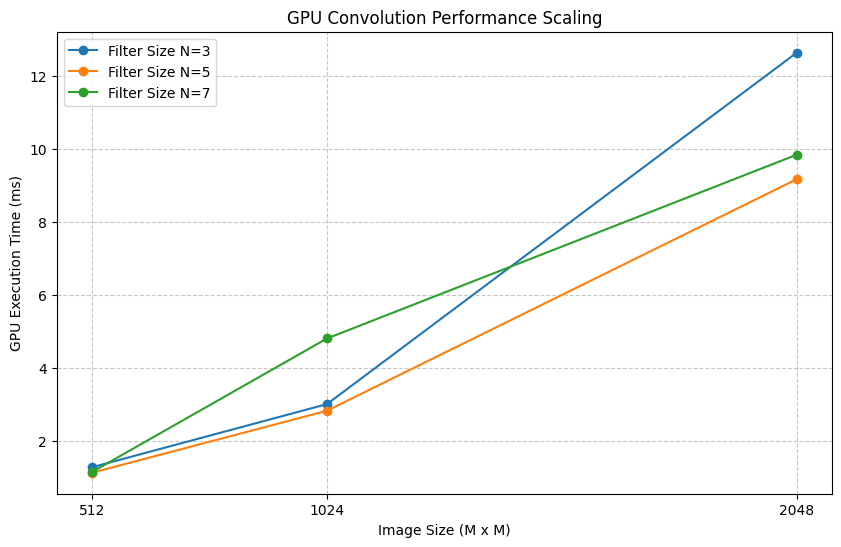

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# benchmark results data
data = [
    {"M": 512, "N": 3, "Time": 1.2915},
    {"M": 512, "N": 5, "Time": 1.1411},
    {"M": 512, "N": 7, "Time": 1.1628},
    {"M": 1024, "N": 3, "Time": 3.0174},
    {"M": 1024, "N": 5, "Time": 2.8369},
    {"M": 1024, "N": 7, "Time": 4.8115},
    {"M": 2048, "N": 3, "Time": 12.6252},
    {"M": 2048, "N": 5, "Time": 9.1662},
    {"M": 2048, "N": 7, "Time": 9.8355}
]

df = pd.DataFrame(data)

# Create the line graph
plt.figure(figsize=(10, 6))
for n in df['N'].unique():
    subset = df[df['N'] == n]
    plt.plot(subset['M'], subset['Time'], marker='o', label=f'Filter Size N={n}')

plt.xlabel('Image Size (M x M)')
plt.ylabel('GPU Execution Time (ms)')
plt.title('GPU Convolution Performance Scaling')
plt.xticks([512, 1024, 2048])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [25]:
# CPU C code
with open('conv_cpu.c', 'w') as f:
    f.write('''
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void convolutionCPU(unsigned int *image, unsigned int *mask, unsigned int *output, int M, int N) {
    int offset = N / 2;
    for (int r = 0; r < M; r++) {
        for (int c = 0; c < M; c++) {
            unsigned int res = 0;
            for (int i = 0; i < N; i++) {
                for (int j = 0; j < N; j++) {
                    int row = r - offset + i;
                    int col = c - offset + j;
                    if (row >= 0 && row < M && col >= 0 && col < M)
                        res += image[row * M + col] * mask[i * N + j];
                }
            }
            output[r * M + c] = res;
        }
    }
}

int main(int argc, char **argv) {
    int M = atoi(argv[1]), N = atoi(argv[2]);
    unsigned int *img = malloc(M*M*sizeof(int)), *msk = malloc(N*N*sizeof(int)), *out = malloc(M*M*sizeof(int));
    clock_t start = clock();
    convolutionCPU(img, msk, out, M, N);
    printf("%f", (double)(clock() - start) / CLOCKS_PER_SEC);
    free(img); free(msk); free(out);
    return 0;
}
''')

# CUDA code (shared library & executable)
with open('matrix_lib.cu', 'w') as f:
    f.write('''
#include <cuda_runtime.h>
#include <stdio.h>

__global__ void convolutionGPU(unsigned int *image, unsigned int *mask, unsigned int *output, int M, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M && col < M) {
        unsigned int res = 0; int offset = N / 2;
        for (int i = 0; i < N; i++) {
            for (int j = 0; j < N; j++) {
                int r = row - offset + i, c = col - offset + j;
                if (r >= 0 && r < M && c >= 0 && c < M)
                    res += image[r * M + c] * mask[i * N + j];
            }
        }
        output[row * M + col] = res;
    }
}

extern "C" void gpu_convolution(unsigned int *h_image, unsigned int *h_mask, unsigned int *h_output, int M, int N) {
    unsigned int *d_i, *d_m, *d_o;
    cudaMalloc(&d_i, M*M*4); cudaMalloc(&d_m, N*N*4); cudaMalloc(&d_o, M*M*4);
    cudaMemcpy(d_i, h_image, M*M*4, cudaMemcpyHostToDevice);
    cudaMemcpy(d_m, h_mask, N*N*4, cudaMemcpyHostToDevice);
    dim3 thr(16, 16); dim3 blk((M+15)/16, (M+15)/16);
    convolutionGPU<<<blk, thr>>>(d_i, d_m, d_o, M, N);
    cudaDeviceSynchronize();
    cudaMemcpy(h_output, d_o, M*M*4, cudaMemcpyDeviceToHost);
    cudaFree(d_i); cudaFree(d_m); cudaFree(d_o);
}
''')

# Compile both
!gcc -O3 conv_cpu.c -o conv_cpu_exec
!nvcc -Xcompiler -fPIC -shared matrix_lib.cu -o libmatrix.so

In [29]:
%%writefile conv_gpu_standalone.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

__global__ void convolutionGPU(unsigned int *image, unsigned int *mask, unsigned int *output, int M, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;
    if (row < M && col < M) {
        unsigned int res = 0;
        int offset = N / 2;
        for (int i = 0; i < N; i++) {
            for (int j = 0; j < N; j++) {
                int r = row - offset + i;
                int c = col - offset + j;
                if (r >= 0 && r < M && c >= 0 && c < M)
                    res += image[r * M + c] * mask[i * N + j];
            }
        }
        output[row * M + col] = res;
    }
}

int main(int argc, char **argv) {
    int M = atoi(argv[1]);
    int N = atoi(argv[2]);
    size_t img_size = (size_t)M * M * sizeof(unsigned int);
    size_t mask_size = (size_t)N * N * sizeof(unsigned int);

    unsigned int *h_i = (unsigned int*)malloc(img_size);
    unsigned int *h_m = (unsigned int*)malloc(mask_size);
    unsigned int *h_o = (unsigned int*)malloc(img_size);
    unsigned int *d_i, *d_m, *d_o;

    cudaMalloc(&d_i, img_size); cudaMalloc(&d_m, mask_size); cudaMalloc(&d_o, img_size);
    cudaMemcpy(d_i, h_i, img_size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_m, h_m, mask_size, cudaMemcpyHostToDevice);

    dim3 threads(16, 16);
    dim3 blocks((M + 15) / 16, (M + 15) / 16);

    cudaEvent_t start, stop;
    cudaEventCreate(&start); cudaEventCreate(&stop);
    cudaEventRecord(start);
    convolutionGPU<<<blocks, threads>>>(d_i, d_m, d_o, M, N);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("%f", ms / 1000.0); // Output in seconds for consistency

    cudaFree(d_i); cudaFree(d_m); cudaFree(d_o);
    free(h_i); free(h_m); free(h_o);
    return 0;
}

Overwriting conv_gpu_standalone.cu


In [30]:
!nvcc conv_gpu_standalone.cu -o conv_gpu_exec

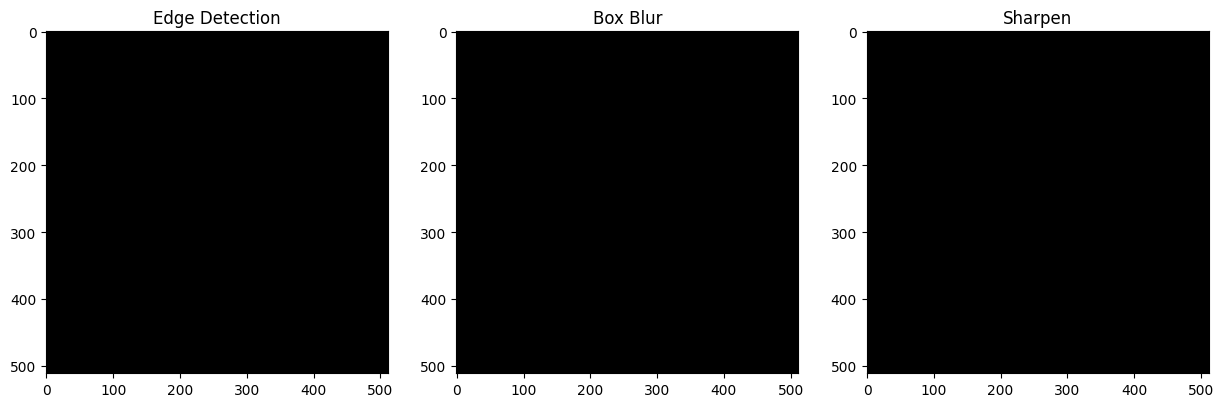


Final Performance Comparison
   M  N    C_ms  CUDA_Direct_ms  Python_Lib_ms  Total_Acceleration
 512  3   3.705           7.712       1.420498            2.608240
 512  5   8.525           7.821       1.590729            5.359179
 512  7  15.127           7.252       1.442194           10.488880
1024  3  15.096           7.193       3.128052            4.826007
1024  5  33.261           7.171       3.109694           10.695909
1024  7  60.717           7.416       3.079414           19.717061
2048  3  59.750           7.440      15.179157            3.936319
2048  5 130.771           7.162      17.673492            7.399273
2048  7 260.529           7.295       9.142876           28.495302


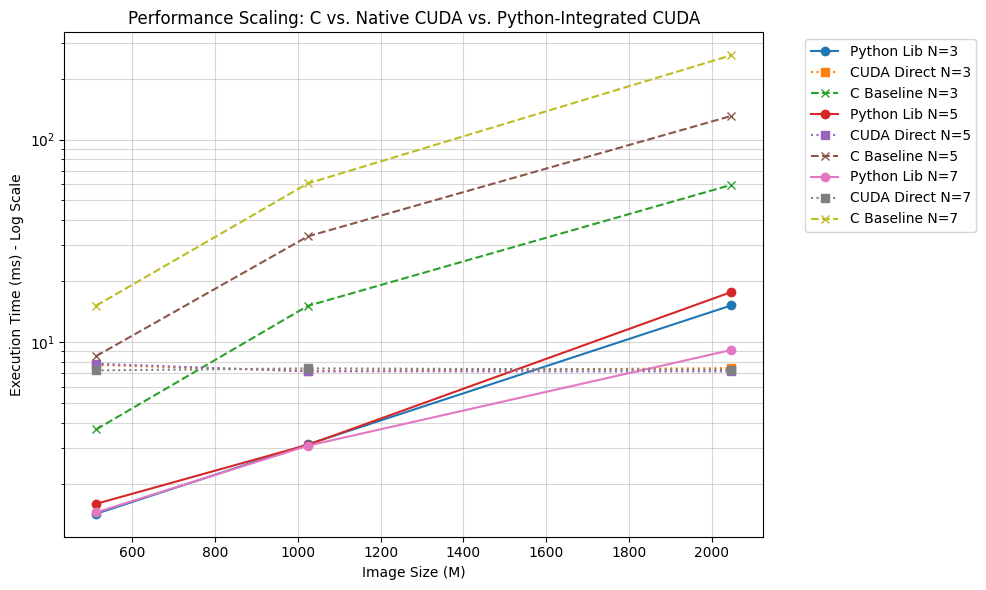

In [31]:
import ctypes, time, subprocess, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import datasets

# Setup library
lib = ctypes.CDLL('./libmatrix.so')
lib.gpu_convolution.argtypes = [np.ctypeslib.ndpointer(dtype=np.uint32), np.ctypeslib.ndpointer(dtype=np.uint32),
                                np.ctypeslib.ndpointer(dtype=np.uint32), ctypes.c_int, ctypes.c_int]

# Create a few image processing filters
img = datasets.face(gray=True)[:512, :512].astype(np.uint32)
edge = np.array([-1,-1,-1, -1,8,-1, -1,-1,-1], dtype=np.int32).view(np.uint32)
blur = np.ones(9, dtype=np.uint32) # Simple 3x3 box blur
sharp = np.array([0,-1,0, -1,5,-1, 0,-1,0], dtype=np.int32).view(np.uint32)

filters = [("Edge Detection", edge), ("Box Blur", blur), ("Sharpen", sharp)]
plt.figure(figsize=(15, 5))
for i, (name, f) in enumerate(filters):
    out = np.zeros_like(img)
    lib.gpu_convolution(img.flatten(), f, out.flatten(), 512, 3)
    plt.subplot(1, 3, i+1); plt.imshow(out, cmap='gray'); plt.title(name)
plt.show()

results = []
for M in [512, 1024, 2048]:
    for N in [3, 5, 7]:
        i, m, o = np.random.randint(0,256,M*M,dtype=np.uint32), np.ones(N*N,dtype=np.uint32), np.zeros(M*M,dtype=np.uint32)

        # 1. Non-accelerated C program (Direct Executable)
        res_cpu = subprocess.run(['./conv_cpu_exec', str(M), str(N)], capture_output=True, text=True)
        cpu_ms = float(res_cpu.stdout) * 1000

        # 2. Directly executed CUDA executable (Direct Executable)
        # Ensure you have compiled conv_gpu_standalone.cu to conv_gpu_exec
        res_gpu_direct = subprocess.run(['./conv_gpu_exec', str(M), str(N)], capture_output=True, text=True)
        gpu_direct_ms = float(res_gpu_direct.stdout) * 1000

        # 3. CUDA-accelerated Python program (Using Shared Lib via ctypes)
        t0 = time.time()
        lib.gpu_convolution(i, m, o, M, N)
        python_gpu_ms = (time.time() - t0) * 1000

        results.append({
            "M": M,
            "N": N,
            "C_ms": cpu_ms,
            "CUDA_Direct_ms": gpu_direct_ms,
            "Python_Lib_ms": python_gpu_ms,
            "Total_Acceleration": cpu_ms / python_gpu_ms
        })

df = pd.DataFrame(results)
print("\nFinal Performance Comparison")
print(df.to_string(index=False))

# Updated plot to compare all three methods
plt.figure(figsize=(10, 6))
for n in [3, 5, 7]:
    sub = df[df['N'] == n]
    plt.plot(sub['M'], sub['Python_Lib_ms'], marker='o', label=f'Python Lib N={n}')
    plt.plot(sub['M'], sub['CUDA_Direct_ms'], marker='s', linestyle=':', label=f'CUDA Direct N={n}')
    plt.plot(sub['M'], sub['C_ms'], marker='x', linestyle='--', label=f'C Baseline N={n}')

plt.yscale('log') # Log scale is essential due to the massive gap between C and CUDA
plt.xlabel('Image Size (M)')
plt.ylabel('Execution Time (ms) - Log Scale')
plt.title('Performance Scaling: C vs. Native CUDA vs. Python-Integrated CUDA')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()